# AI Observer - Tabular model

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.tabular import *
import torch
import pandas as pd
torch.cuda.get_device_properties(0)
import xgboost as xgb

In [4]:
path = Path("/home/alan/Desktop/personal_professional/fastai/mushroom_classifier")

In [5]:
df_4 = pd.read_csv(path / "resources/ds4_100mostPopSpecies.csv")
df_4.head()

,id,text_name,thumb_image_id,name_id,when,vote_cache,lat,long,alt,where,...,west,high,low,is_collection_location,notes,preferred_name,rank,is_validation,image_id,observation_id
0,273528,Amanita calyptroderma,728029.0,159,2016-11-26,1.61993,-14.4985,-18.4351,-4497.0,"Hood Mountain Regional Park, Santa Rosa, Calif...",...,-122.5780,NaN,NaN,1,---\n:Other: Solitary under live oak\n,Amanita calyptroderma,4,False,728027,273528
1,273528,Amanita calyptroderma,728029.0,159,2016-11-26,1.61993,-14.4985,-18.4351,-4497.0,"Hood Mountain Regional Park, Santa Rosa, Calif...",...,-122.5780,NaN,NaN,1,---\n:Other: Solitary under live oak\n,Amanita calyptroderma,4,False,728028,273528
2,273528,Amanita calyptroderma,728029.0,159,2016-11-26,1.61993,-14.4985,-18.4351,-4497.0,"Hood Mountain Regional Park, Santa Rosa, Calif...",...,-122.5780,NaN,NaN,1,---\n:Other: Solitary under live oak\n,Amanita calyptroderma,4,False,728029,273528
3,273528,Amanita calyptroderma,728029.0,159,2016-11-26,1.61993,-14.4985,-18.4351,-4497.0,"Hood Mountain Regional Park, Santa Rosa, Calif...",...,-122.5780,NaN,NaN,1,---\n:Other: Solitary under live oak\n,Amanita calyptroderma,4,False,728030,273528
4,296795,Leotia lubrica,806494.0,188,2017-09-04,2.50613,46.6596,-88.7104,243.0,"Ottawa National Forest, Michigan, USA",...,-90.4185,NaN,NaN,1,--- {}\n,Leotia viscosa,4,False,806494,296795


In [6]:
df_4.columns

Index(['id', 'text_name', 'thumb_image_id', 'name_id', 'when', 'vote_cache',
       'lat', 'long', 'alt', 'where', 'north', 'south', 'east', 'west', 'high',
       'low', 'is_collection_location', 'notes', 'preferred_name', 'rank',
       'is_validation', 'image_id', 'observation_id'],
      dtype='object')

In [7]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [8]:
add_datepart(df_4, "when")

In [9]:
df_4.head()

,id,text_name,thumb_image_id,name_id,vote_cache,lat,long,alt,where,north,...,whenDay,whenDayofweek,whenDayofyear,whenIs_month_end,whenIs_month_start,whenIs_quarter_end,whenIs_quarter_start,whenIs_year_end,whenIs_year_start,whenElapsed
0,273528,Amanita calyptroderma,728029.0,159,1.61993,-14.4985,-18.4351,-4497.0,"Hood Mountain Regional Park, Santa Rosa, Calif...",38.443,...,26,5,331,False,False,False,False,False,False,1480118400
1,273528,Amanita calyptroderma,728029.0,159,1.61993,-14.4985,-18.4351,-4497.0,"Hood Mountain Regional Park, Santa Rosa, Calif...",38.443,...,26,5,331,False,False,False,False,False,False,1480118400
2,273528,Amanita calyptroderma,728029.0,159,1.61993,-14.4985,-18.4351,-4497.0,"Hood Mountain Regional Park, Santa Rosa, Calif...",38.443,...,26,5,331,False,False,False,False,False,False,1480118400
3,273528,Amanita calyptroderma,728029.0,159,1.61993,-14.4985,-18.4351,-4497.0,"Hood Mountain Regional Park, Santa Rosa, Calif...",38.443,...,26,5,331,False,False,False,False,False,False,1480118400
4,296795,Leotia lubrica,806494.0,188,2.50613,46.6596,-88.7104,243.0,"Ottawa National Forest, Michigan, USA",46.765,...,4,0,247,False,False,False,False,False,False,1504483200


In [10]:
df_4.columns

Index(['id', 'text_name', 'thumb_image_id', 'name_id', 'vote_cache', 'lat',
       'long', 'alt', 'where', 'north', 'south', 'east', 'west', 'high', 'low',
       'is_collection_location', 'notes', 'preferred_name', 'rank',
       'is_validation', 'image_id', 'observation_id', 'whenYear', 'whenMonth',
       'whenWeek', 'whenDay', 'whenDayofweek', 'whenDayofyear',
       'whenIs_month_end', 'whenIs_month_start', 'whenIs_quarter_end',
       'whenIs_quarter_start', 'whenIs_year_end', 'whenIs_year_start',
       'whenElapsed'],
      dtype='object')

In [11]:
procs=[FillMissing, Categorify, Normalize]

In [12]:
cat_vars = ['where', 'is_collection_location',
            'whenYear', 'whenMonth', 'whenWeek',
            'whenDay', 'whenDayofyear', 'whenIs_month_end',
            'whenDayofweek',
            'whenIs_month_start', 'whenIs_quarter_end', 'whenIs_quarter_start',
            'whenIs_year_end', 'whenIs_year_start', 'whenElapsed']

cont_vars = ['lat', 'long', 'alt', 'north', 'south', 'east', 'west', 'high', 'low']

In [26]:
data = (TabularList.from_df(df_4, path=path / "resources", cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
        .split_from_df("is_validation")
        .label_from_df("preferred_name")
        .databunch(bs=1024))

In [27]:
doc(tabular_learner)

In [28]:
learn = tabular_learner(data, layers=[512, 256], ps=[0.7, 0.7], emb_drop=0.7, wd=0.1,
                        metrics=[accuracy, top_k_accuracy])

In [29]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6867, 225)
    (1): Embedding(3, 3)
    (2): Embedding(40, 13)
    (3): Embedding(13, 7)
    (4): Embedding(54, 15)
    (5): Embedding(32, 11)
    (6): Embedding(367, 44)
    (7): Embedding(3, 3)
    (8): Embedding(8, 5)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(4657, 181)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.7, inplace=False)
  (bn_cont): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=546, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=512, out_features=256

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 2.51E-02


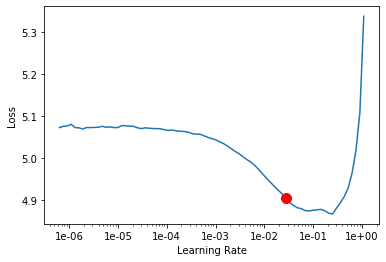

In [30]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [31]:
learn.fit_one_cycle(3, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.381453,3.975871,0.087349,0.271704,00:01
1,3.754339,3.806644,0.111111,0.314377,00:01
2,3.376158,3.844259,0.117074,0.317403,00:01


In [32]:
learn.save("tabular_4_100topSpecies")

In [62]:
learn.export("tabular_4_min10obs.pkl")

### Gradient boosting machines

In [12]:
dtrain = df_4[~df_4.is_validation][cat_vars + cont_vars]
dtrain["where"] = dtrain["where"].astype("category")
dtrain["where"] = dtrain["where"].cat.codes
tlabel = df_4[~df_4.is_validation]["preferred_name"]
tlabel = tlabel.astype("category")
tlabel = tlabel.cat.codes


dval = df_4[df_4.is_validation][cat_vars + cont_vars]
dval["where"] = dval["where"].astype("category")
dval["where"] = dval["where"].cat.codes
vlabel = df_4[df_4.is_validation]["preferred_name"]
vlabel = vlabel.astype("category").cat.codes

dtrain = xgb.DMatrix(dtrain, tlabel, feature_names=dtrain.columns)
dval = xgb.DMatrix(dval, vlabel, feature_names=dval.columns)

In [14]:
watchlist = [ (dtrain,'train'), (dval, 'validation') ]
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'multi:softprob', "num_class": 2894,
         'tree_method': 'gpu_hist', 'gpu_id': 0}
bst = xgb.train(param, dtrain, 2, watchlist, early_stopping_rounds=50, maximize=True);
yprob = bst.predict( dval ).reshape( ytest.shape[0], 100 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % \
       (np.sum( ylabel != vlabel) / float(len(vlabel)) ))

XGBoostError: [01:08:11] /home/conda/feedstock_root/build_artifacts/xgboost_1584539733809/work/include/xgboost/gbm.h:166: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /home/alan/anaconda3/envs/mushroom_api/lib/libxgboost.so(+0x8871f) [0x7efb84fcf71f]
  [bt] (1) /home/alan/anaconda3/envs/mushroom_api/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0x106) [0x7efb850939d6]
  [bt] (2) /home/alan/anaconda3/envs/mushroom_api/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x27f) [0x7efb850a2a8f]
  [bt] (3) /home/alan/anaconda3/envs/mushroom_api/lib/libxgboost.so(+0x187857) [0x7efb850ce857]
  [bt] (4) /home/alan/anaconda3/envs/mushroom_api/lib/libxgboost.so(+0x181e8e) [0x7efb850c8e8e]
  [bt] (5) /home/alan/anaconda3/envs/mushroom_api/lib/libxgboost.so(XGBoosterUpdateOneIter+0x3c) [0x7efb84fd0b6c]
  [bt] (6) /home/alan/anaconda3/envs/mushroom_api/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7efc27a3c630]
  [bt] (7) /home/alan/anaconda3/envs/mushroom_api/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7efc27a3bfed]
  [bt] (8) /home/alan/anaconda3/envs/mushroom_api/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7efc27a5300e]



## Genera

In [37]:
df_9 = pd.read_csv(path / "resources/ds9_min10obs.csv")
df_9.head()

,id,text_name,thumb_image_id,name_id,when,vote_cache,lat,long,alt,where,...,west,high,low,is_collection_location,notes,preferred_name,rank,is_validation,image_id,observation_id
0,394749,Trichoderma,1128098.0,20284,2019-11-30,1.38302,35.6871,-90.3994,67.0,"Saint Francis Sunken Lands WMA, Craighead Co.,...",...,-90.4769,NaN,NaN,1,---\n:Other: Mixed hardwood/pine bottom land w...,Trichoderma,9,False,1128097,394749
1,394749,Trichoderma,1128098.0,20284,2019-11-30,1.38302,35.6871,-90.3994,67.0,"Saint Francis Sunken Lands WMA, Craighead Co.,...",...,-90.4769,NaN,NaN,1,---\n:Other: Mixed hardwood/pine bottom land w...,Trichoderma,9,False,1128098,394749
2,309326,Lactarius chrysorrheus,848101.0,6315,2017-09-02,1.68705,45.4538,-84.6000,205.0,"Topinabee, Michigan, USA",...,-84.6105,NaN,NaN,1,--- {}\n,Lactarius,9,False,848101,309326
3,309326,Lactarius chrysorrheus,848101.0,6315,2017-09-02,1.68705,45.4538,-84.6000,205.0,"Topinabee, Michigan, USA",...,-84.6105,NaN,NaN,1,--- {}\n,Lactarius,9,False,848102,309326
4,361407,Acarospora socialis,1014874.0,6799,2019-03-14,1.36036,NaN,NaN,NaN,"Bastrop State Park, Bastrop Co., Texas, USA",...,-97.2883,NaN,NaN,1,---\n:Other: On sandstone of CCC Pavilion of L...,Acarospora,9,False,1014863,361407


In [38]:
add_datepart(df_9, "when")

In [39]:
df_9.head()

,id,text_name,thumb_image_id,name_id,vote_cache,lat,long,alt,where,north,...,whenDay,whenDayofweek,whenDayofyear,whenIs_month_end,whenIs_month_start,whenIs_quarter_end,whenIs_quarter_start,whenIs_year_end,whenIs_year_start,whenElapsed
0,394749,Trichoderma,1128098.0,20284,1.38302,35.6871,-90.3994,67.0,"Saint Francis Sunken Lands WMA, Craighead Co.,...",35.9815,...,30,5,334,True,False,False,False,False,False,1575072000
1,394749,Trichoderma,1128098.0,20284,1.38302,35.6871,-90.3994,67.0,"Saint Francis Sunken Lands WMA, Craighead Co.,...",35.9815,...,30,5,334,True,False,False,False,False,False,1575072000
2,309326,Lactarius chrysorrheus,848101.0,6315,1.68705,45.4538,-84.6000,205.0,"Topinabee, Michigan, USA",45.5489,...,2,5,245,False,False,False,False,False,False,1504310400
3,309326,Lactarius chrysorrheus,848101.0,6315,1.68705,45.4538,-84.6000,205.0,"Topinabee, Michigan, USA",45.5489,...,2,5,245,False,False,False,False,False,False,1504310400
4,361407,Acarospora socialis,1014874.0,6799,1.36036,NaN,NaN,NaN,"Bastrop State Park, Bastrop Co., Texas, USA",30.1115,...,14,3,73,False,False,False,False,False,False,1552521600


In [40]:
df_9.columns

Index(['id', 'text_name', 'thumb_image_id', 'name_id', 'vote_cache', 'lat',
       'long', 'alt', 'where', 'north', 'south', 'east', 'west', 'high', 'low',
       'is_collection_location', 'notes', 'preferred_name', 'rank',
       'is_validation', 'image_id', 'observation_id', 'whenYear', 'whenMonth',
       'whenWeek', 'whenDay', 'whenDayofweek', 'whenDayofyear',
       'whenIs_month_end', 'whenIs_month_start', 'whenIs_quarter_end',
       'whenIs_quarter_start', 'whenIs_year_end', 'whenIs_year_start',
       'whenElapsed'],
      dtype='object')

In [41]:
data_9 = (TabularList.from_df(df_9, path=path / "resources", cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
        .split_from_df("is_validation")
        .label_from_df("preferred_name")
        .databunch())

In [52]:
learn_9 = tabular_learner(data_9, layers=[1000,500], ps=[0.7,0.7], emb_drop=0.7,
                          metrics=[accuracy, top_k_accuracy])

In [53]:
learn_9.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(17494, 380)
    (1): Embedding(3, 3)
    (2): Embedding(71, 17)
    (3): Embedding(13, 7)
    (4): Embedding(54, 15)
    (5): Embedding(32, 11)
    (6): Embedding(8, 5)
    (7): Embedding(367, 44)
    (8): Embedding(3, 3)
    (9): Embedding(8, 5)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(6273, 214)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(3, 3)
    (21): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.7, inplace=False)
  (bn_cont): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=746, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=F

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 3.98E-03


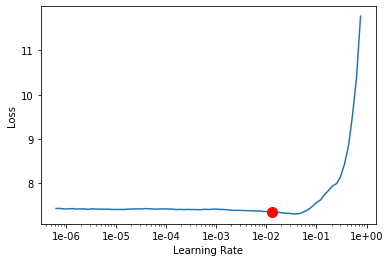

In [54]:
learn_9.lr_find()
learn_9.recorder.plot(suggestion=True)

In [55]:
learn_9.fit_one_cycle(5, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.084203,4.922719,0.106729,0.257033,04:53
1,4.829039,4.798566,0.118942,0.275495,04:59
2,4.715781,4.770739,0.122907,0.282041,05:00
3,4.611536,4.759884,0.123038,0.285336,05:01
4,4.576232,4.770238,0.122902,0.285131,05:01


In [60]:
learn_9.save("tabular_9_min10obs")

In [61]:
learn_9.export("tabular_9_min10obs.pkl")